# Machine Learning for Time Series (Master MVA, tutorial 1)



### Library imports

In [1]:
from sporco.admm import cbpdn
from sporco.dictlrn import cbpdndl

from numpy.random import RandomState

rng = RandomState(seed=1234)




import matplotlib.pyplot as plt
import numpy as np
from loadmydata.load_uea_ucr import load_uea_ucr_data
from loadmydata.padding import get_signal_shape
from sporco import plot, util


### Utility functions

In [2]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal.
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [3]:
def atleast_2d(ary):
    """Reshape array to at least two dimensions."""
    if ary.ndim == 0:
        return ary.reshape(1, 1)
    elif ary.ndim == 1:
        return ary[:, np.newaxis]
    return ary

# Data exploration

In [4]:
dataset_name = "AtrialFibrillation"
data = load_uea_ucr_data(dataset_name)
print(data.description)

ECG_AtrialFibrilation Description:
This dataset of two-channel ECG recordings has been created from data used in the Computers in Cardiology Challenge 2004, an open competition with the goal of developing automated methods for predicting spontaneous termination of atrial fibrillation (AF).
The raw instances were 5 second segments of atrial fibrillation, containing two ECG signals, each sampled at 128 samples per second.
The Multivate data organises these channels such that each is one dimension.
The class labels are: n, s and t.
class n is described as a non termination artiral fibrilation(that is, it did not terminate for at least one hour after the original recording of the data).
class s is described as an atrial fibrilation that self terminates at least one minuet after the recording process.
class t is descirbed as terminating immediatly, that is within one second of the recording ending.

ECG_AtrialFibrilation Reference:
Webpage: https://www.physionet.org/physiobank/database/aftd

Training set:	15 time series with 640 samples and 2 dimensions.
Testing set:	15 time series with 640 samples and 2 dimensions.



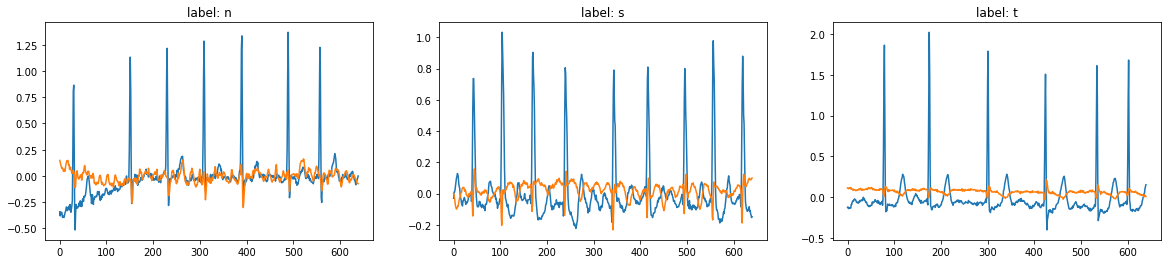

In [5]:
msg = "{title} set:\t{n_series} time series with {n_samples} samples and {n_dims} dimensions."
for title, X in zip(("Training", "Testing"), (data.X_train, data.X_test)):
    n_series, n_samples, n_dims = X.shape
    print(
        msg.format(
            title=title, n_series=n_series, n_samples=n_samples, n_dims=n_dims
        )
    )
print()

fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
for ind, ax in zip([0, 5, 10], ax_arr):
    s = data.X_train[ind]
    ax.plot(s)
    _ = ax.set_title(f"label: {data.y_train[ind]}")

## Convolutional dictionary learning (CDL)

### CDL on a single signal

In [49]:
# parameters
n_atoms = 2
atom_length = 20
penalty = 1.0

# Select first dimension of the first element of X_train
signal = data.X_train[0, :, 0]
signal = atleast_2d(signal)  # reshape

# options for the dictionary learning and sparse coding procedures
opt_dl = cbpdndl.ConvBPDNDictLearn.Options(
    {
        "Verbose": False,
        "MaxMainIter": 400,
        "CBPDN": {"rho": 50.0 * penalty + 0.5},
        "CCMOD": {"rho": 10.0},
    },
    dmethod="cns",
)
opt_sc = cbpdn.ConvBPDN.Options(
    {
        "Verbose": False,
        "MaxMainIter": 200,
        "RelStopTol": 5e-3,
        "AuxVarObj": False,
    }
)

# Dictionary learning and sparse coding
atom_dictionary = cbpdndl.ConvBPDNDictLearn(
    rng.randn(atom_length, 1, n_atoms),  # random init
    signal,
    penalty,
    opt_dl,
    dmethod="cns",
).solve()

# retrieve the sparse codes
sparse_codes = (
    cbpdn.ConvBPDN(
        atom_dictionary,
        signal,
        penalty,
        opt_sc,
    )
    .solve()
    .squeeze()
)

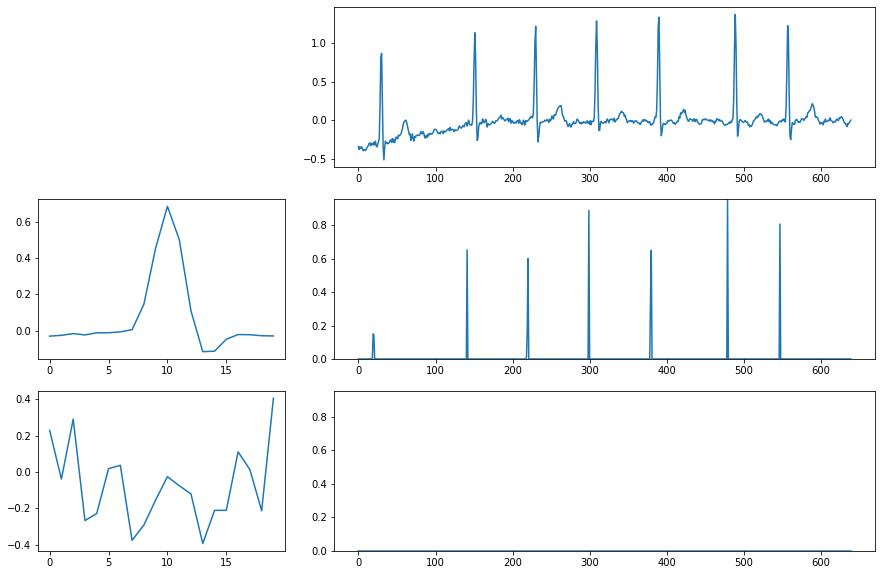

In [18]:
plot_CDL(
    signal, atleast_2d(sparse_codes), atleast_2d(atom_dictionary.squeeze())
)

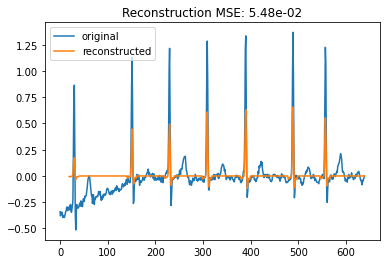

In [46]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = np.sum(
    [
        np.convolve(codes, atom, mode="valid")
        for (codes, atom) in zip(sparse_codes.T, atom_dictionary.squeeze().T)
    ],
    axis=0,
)

# Note that the reconstruction has less samples than the original signal.
# This is because of border effects of the convolution.

tt = np.arange(signal.shape[0])
plt.plot(tt, signal, label="original")
plt.plot(tt[atom_length - 1 :], reconstruction, label="reconstructed")
plt.title(f"Reconstruction MSE: {np.mean((signal-reconstruction)**2):.2e}")
plt.legend()

## CDL on the data set

<div class="alert alert-success" role="alert">
    <h4 class="alert-heading">Question</h4>
    Extract one or several motifs from each of the training time series.
    <br>
    For each signal, choose the number <tt>n_atoms</tt> of atoms, the length <tt>atom_length</tt> and the penalty value <tt>penalty</tt> based on the total recontruction error.
    <br>
    For the optimal set of parameters, plot both the best and the worst approximations.
    <hr>
    <b>Tip</b>: make a class with a <tt>.fit(signal)</tt> and a <tt>.predict(signal)</tt> methods.
</div>

# Distance between signals